In [296]:
import pandas as pd
df = pd.read_csv("fact_price_weekly_cheese.csv")

In [297]:
df.drop(["fact","CHEESE","unit","source","product_code","date"], axis=1, inplace=True)

In [298]:
df = pd.get_dummies(df, columns = ['geo', 'geo_partner'])

In [299]:
df["product"] = df["product"].astype('category').cat.codes

In [300]:
df.head()

,year,month,yearmonth,product_sk,product,currency_sk,curr_value,lag_value,geo_EU,geo_NEW ZEALAND,geo_OCEANIA,geo_UNITED KINGDOM,geo_UNITED STATES,geo_partner_ns
0,2016,10,201610,1731,1,408690,4.0333,0,0,0,0,0,1,1
1,2016,10,201610,1729,2,408624,3.0500,0,0,0,0,1,0,1
2,2016,10,201610,1728,3,408624,3.0250,0,0,0,0,1,0,1
3,2016,10,201610,1727,0,408624,3.8875,0,0,0,1,0,0,1
4,2016,10,201610,1731,1,408624,4.1270,0,0,0,0,0,1,1


In [302]:
df["curr_value"] = df["curr_value"].fillna(np.mean(df.curr_value))

In [312]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
df_scaled = min_max_scaler.fit_transform(df)
df_scaled = pd.DataFrame(df_scaled)
df_scaled = df_scaled.astype('float32')

In [313]:
array = np.array(df_scaled)
array = array.reshape((1,2686,14))

In [314]:
df_scaled.shape

(2686, 14)

In [315]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 14  # 80 floats -> compression of factor 0.8, assuming the input is 100 floats

# this is our input placeholder
input = Input(shape=(2686,14))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(14, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(inputs=input, outputs=decoded)

In [316]:
encoder = Model(inputs=input, outputs=encoded)

In [317]:

# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=array.shape[1:])
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(inputs=encoded_input, outputs=decoder_layer(encoded_input))

In [318]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')


In [319]:
# Just compute the distance before learning (show be very bad !)
import numpy as np
test_encode = encoder.predict(array)
test_decode = decoder.predict(test_encode)
test_encode = test_encode.reshape((2686,14))
test_decode = test_decode.reshape((2686,14))
test_array = array.reshape((2686,14))
naivedist = np.zeros(len(df_scaled.values))
for i, x in enumerate(test_array):
    naivedist[i] = np.linalg.norm(x-test_decode[i]) 

In [320]:
df["naivedist"] = naivedist

In [321]:
autoencoder.fit(array, array,
                nb_epoch=2500,
                batch_size=100,
                shuffle=True,
                verbose=0)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


In [322]:
encoded = encoder.predict(array)
decoded = decoder.predict(encoded)

In [323]:
encoded = encoded.reshape((2686,14))
decoded = decoded.reshape((2686,14))
array = array.reshape((2686,14))


In [324]:
import numpy as np

dist = np.zeros(len(df_scaled.values))
for i, x in enumerate(array):
    dist[i] = np.linalg.norm(x-decoded[i]) 

In [325]:
df["dist"] = dist

In [349]:
df["Outlier"] = df.apply(lambda x: 1 if abs(x['dist']) > 0.2 else 0, axis=1)

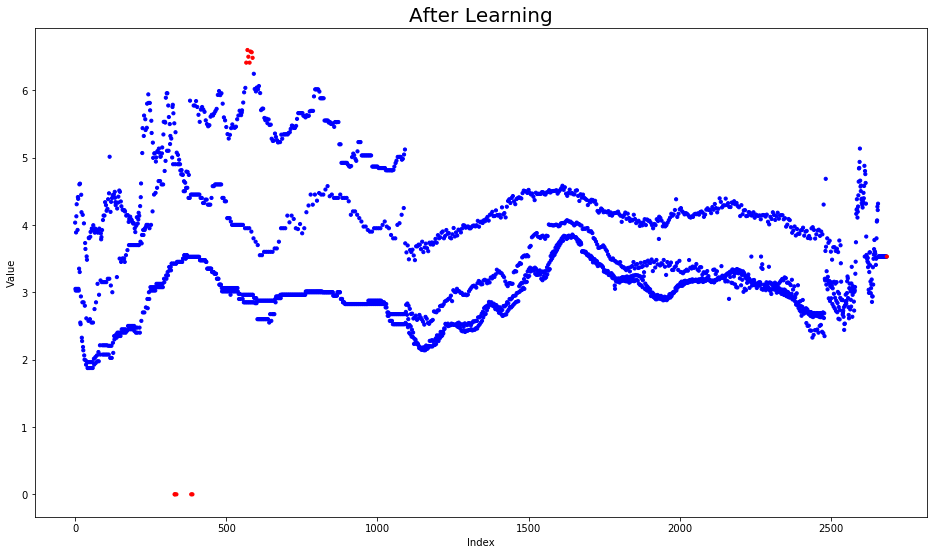

In [363]:
use_colours = {0: "blue", 1: "red"}
#ax.scatter(a,b,c,c=[use_colours[x[0]] for x in df["Outlier"]],s=50)

plt.figure(figsize=(16,9))
plt.scatter(df.index, df['curr_value'], c=[use_colours[x] for x in df["Outlier"]], s=10)
plt.xlabel('Index')
plt.ylabel('Value')
plt.title("After Learning", fontsize="20")


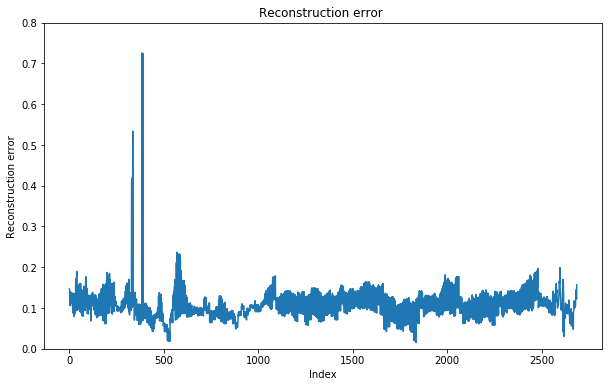

In [291]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(dist)
#plt.xlim((0,100))
plt.ylim((0,0.8))
plt.xlabel('Index')
plt.ylabel('Reconstruction error')
plt.title("Reconstruction error ")